# CHiMaD Workshop: JCAP Example

In [25]:
import h5py    
import numpy as np    
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from dlhub_sdk.client import DLHubClient
from sklearn.ensemble import RandomForestRegressor
from mdf_forge import Forge
%matplotlib inline

### Retrieving Data with MDF Forge

In [29]:
mdf = Forge('mdf-test')

dataset_name = "sstein_stein_bandgap_2020" #GET THE NAME OF THE DATASET FROM TYLER!
r = mdf.match_resource_types("record").match_source_names(dataset_name)
r = r.search()
subset = r[:10]

In [ ]:
### Use HTTPS from endpoint

In [39]:
print(subset[0])

{'files': [{'data_type': 'Hierarchical Data Format (version 5) data', 'filename': 'dataset_comp_image_spectra.h5', 'globus': 'globus://82f1b5c6-6e9b-11e5-ba47-22000b92c6ec/public/demo/jcap/raw/dataset_comp_image_spectra.h5', 'length': 1717287078}], 'material': {'composition': 'Ce1.0', 'elemental_proportions': {'Ce': 1.0}, 'elements': ['Ce']}, 'mdf': {'ingest_date': '2020-06-05T23:05:53.970939Z', 'resource_type': 'record', 'scroll_id': 65162, 'source_id': 'sstein_stein_bandgap_2020_v1.1', 'source_name': 'sstein_stein_bandgap_2020', 'version': 1}}


In [2]:
data = h5py.File('dataset_comp_image_spectra.h5','r+')

In [3]:
atfrac = pd.DataFrame(data['atfrac'].value)
at_frac_keys = data['atfrac_keys'].value
elts_frac_keys = [str(i)[2:str(i).index('.')] for i in at_frac_keys]

/Users/marcus/anaconda2/envs/jcesr_ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [4]:
spectra = data['spectra'].value
energy_eV = data['energy_eV'].value
images = data['images'].value

### Generating Useful Cuts on Thin Films Data

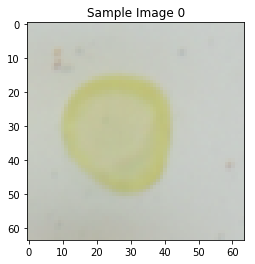

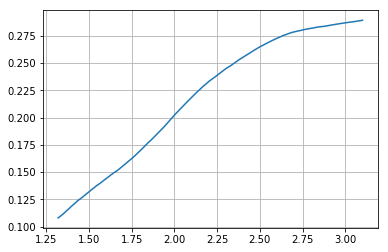

In [6]:
plt.figure()
plt.imshow(images[0])
plt.title('Sample Image 0')
plt.show()

plt.figure()
plt.plot(energy_eV,spectra[0])
plt.grid()
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.show()

### Analysis of Image Features Using A Random Forest Model

In [7]:
shuffled = pd.read_csv('full_shuffled_dataset.csv',index_col=0)
x_train = shuffled.values[:int(0.80*len(shuffled)),:-1]
y_train = shuffled.values[:int(0.80*len(shuffled)),-1]

x_test = shuffled.values[int(0.80*len(shuffled)):,:-1]
y_test = shuffled.values[int(0.80*len(shuffled)):,-1]


In [11]:
rfr = RandomForestRegressor()
rfr.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [42]:
x_test.shape

(35163, 51)

In [12]:
y_out = rfr.predict(x_test)

In [14]:
plot_colors = np.array([i for i in zip(shuffled['R_channel avg'].tolist()[int(0.80*len(shuffled)):],\
                           shuffled['G_channel avg'].tolist()[int(0.80*len(shuffled)):],\
                           shuffled['B_channel avg'].tolist()[int(0.80*len(shuffled)):])])/255.


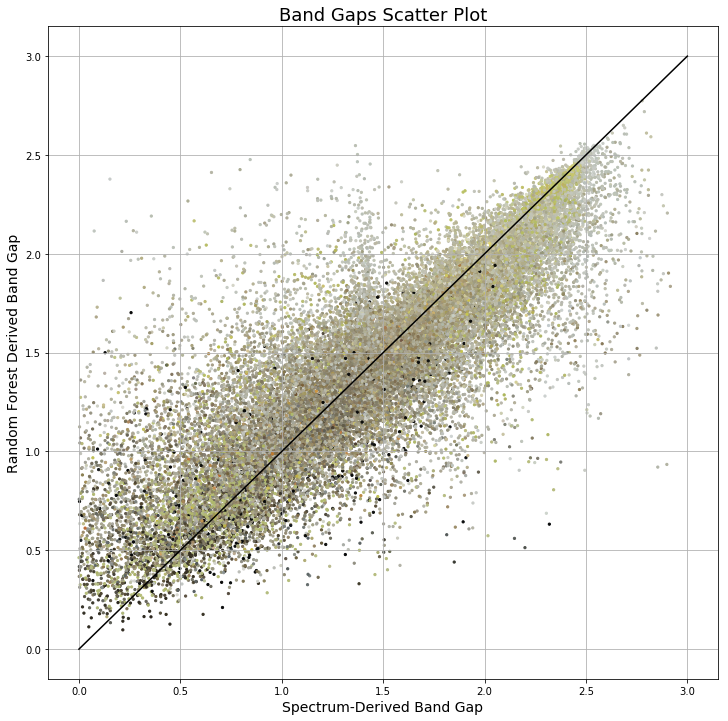

In [15]:
plt.figure(figsize=(12,12))
plt.scatter(y_test,y_out,s=5,alpha=1,color=plot_colors)
plt.xlabel('Spectrum-Derived Band Gap',fontsize=14)
plt.ylabel('Random Forest Derived Band Gap',fontsize=14)
plt.title('Band Gaps Scatter Plot',fontsize=18)
plt.plot([0,3],[0,3],color='black')
plt.grid()
plt.show()

### Using DLHub to Run and Compare Models

In [40]:
DL = DLHubClient()

In [46]:
y_out_DL = DL.run(name = 'mschwarting_anl/Thin_Films_BG_RF', \
                  inputs=np.zeros([3,51]).tolist())[0]

KeyboardInterrupt: 

In [ ]:
'''
plt.figure(figsize=(6,6))
plt.scatter(y_test,y_out,s=3,alpha=0.1,color='red')
plt.xlabel('Spectrum-Derived Band Gap')
plt.ylabel('Random Forest Derived Band Gap')
plt.title('Band Gaps Scatter Plot')
plt.plot([0,3],[0,3],color='black')
plt.show()
error = np.array(y_test)-np.array(y_out)
plt.figure()
plt.xlabel('Frequency (counts)')
plt.ylabel('Spectrum BG - Random Forest BG (eV)')
plt.title('Histogram of Band Gap Error')
plt.hist(error,50)
plt.show()
print('Mean Error: '+str(round(np.average(error)*1000,2))+' meV')
print('Standard Deviation: '+str(round(np.std(error)*1000,2))+' meV')
#sns.distplot(error)
print('MAE: '+str(round(mean_absolute_error(y_test, y_out)*1000,2))+' meV')
print('MSE: '+str(round(mean_squared_error(y_test, y_out)*1000,2))+' meV')
print('RMSE: '+str(round((mean_squared_error(y_test, y_out)**0.5)*1000,2))+' meV')
'''

In [ ]:
#Add DLHub example (after resubmitting container)
#One sitting locally, one from DLHub. See how accuracy of each compares (models different)
#MDF Forge cuts: based on composition, band gaps
#
